In [115]:
%reload_ext autoreload
%autoreload 2

## Influence of time on the ratings

In [116]:
from src.utils.data_utils import load_time_bias_data

time_df_reviews, time_df_beerAdvocate = load_time_bias_data('data')

In [140]:
# Analysis using time and rating per beer style
time_df_reviews_style = time_df_reviews.copy()
# take randomly 10 samples of style
time_df_reviews_style = time_df_reviews_style[time_df_reviews_style['style'].isin(time_df_reviews_style['style'].sample(10, random_state=1))]
time_df_reviews_style = time_df_reviews_style.groupby(['style', 'year', 'month'])['rating'].agg(['mean', 'count'])

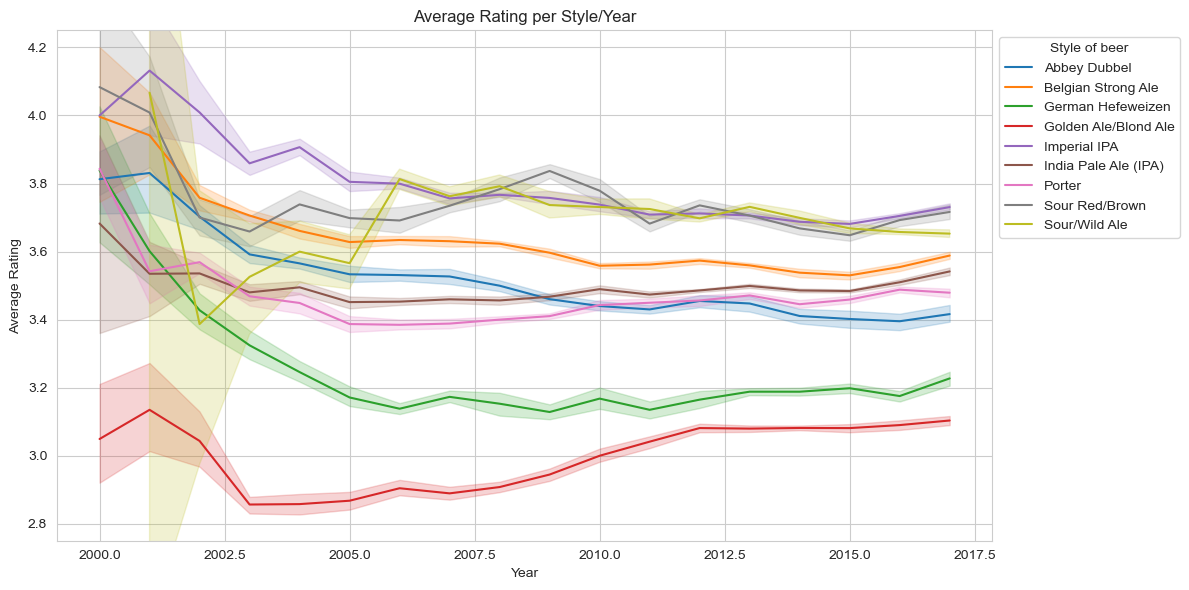

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the average rating per style and year
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_df_reviews_style, x='year', y='mean', hue='style')

plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating per Style/Year')
plt.legend(title='Style of beer', bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(2.75, 4.25)
plt.tight_layout()

In [119]:
import statsmodels.formula.api as smf

time_df_reviews_cat = time_df_reviews.copy()
# Compute the mean of all rating to see which column affect the rating around the mean
mean = time_df_reviews_cat['rating'].mean()
time_df_reviews_cat['binary_rating'] = (time_df_reviews_cat['rating'] >= mean).astype(int)

# Check which columns will impact the most the rating
log = smf.logit(formula='binary_rating ~ year + month + day', data=time_df_reviews_cat)
log = log.fit()
print(log.summary())

Optimization terminated successfully.
         Current function value: 0.668482
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          binary_rating   No. Observations:              6117679
Model:                          Logit   Df Residuals:                  6117675
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                0.008102
Time:                        23:55:08   Log-Likelihood:            -4.0896e+06
converged:                       True   LL-Null:                   -4.1230e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -110.0059      0.431   -255.329      0.000    -110.850    -109.162
year           0.0549      0.

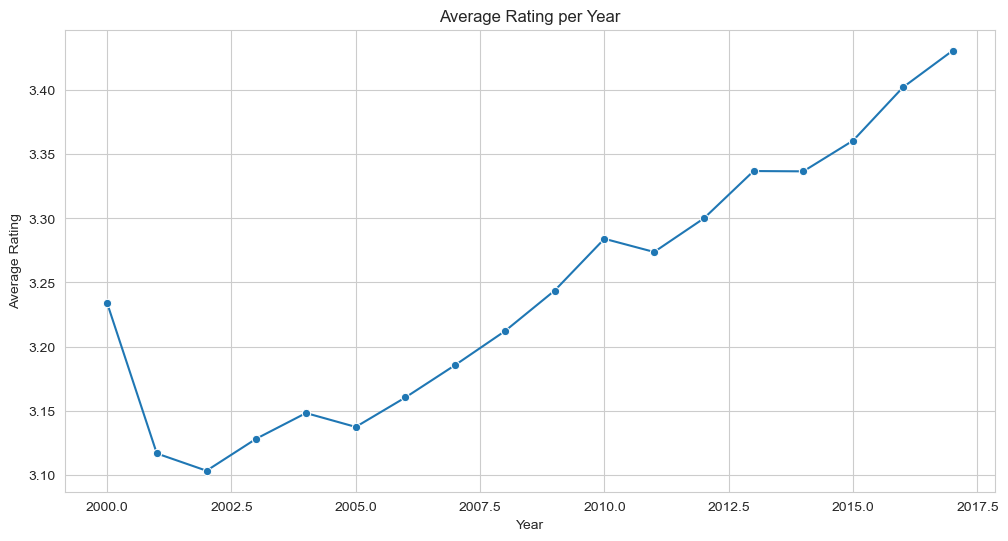

In [120]:
# Compare the average rating per year for all beer for the RateBeer dataset
mean = time_df_reviews.groupby('year')['rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean, x='year', y='rating', marker='o')

plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating per Year')
plt.show()

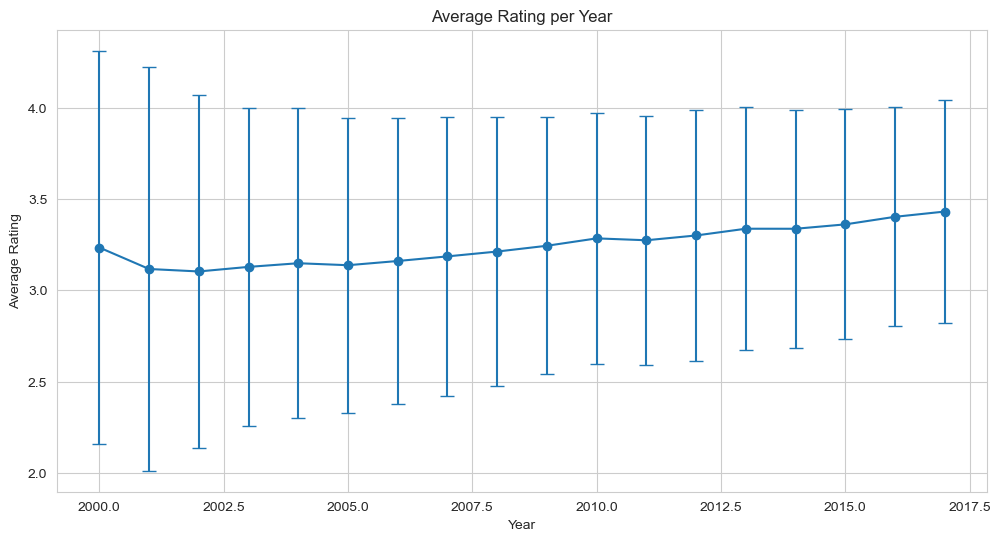

In [121]:
# Compare the average rating per year for all beer with std for the RateBeer dataset
mean = time_df_reviews.groupby('year')['rating'].mean().reset_index()
# Add the standard deviation to the plot
std = time_df_reviews.groupby('year')['rating'].std().reset_index()
plt.figure(figsize=(12, 6))
plt.errorbar(mean['year'], mean['rating'], yerr=std['rating'], capsize=5, marker='o')

plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating per Year')
plt.show()

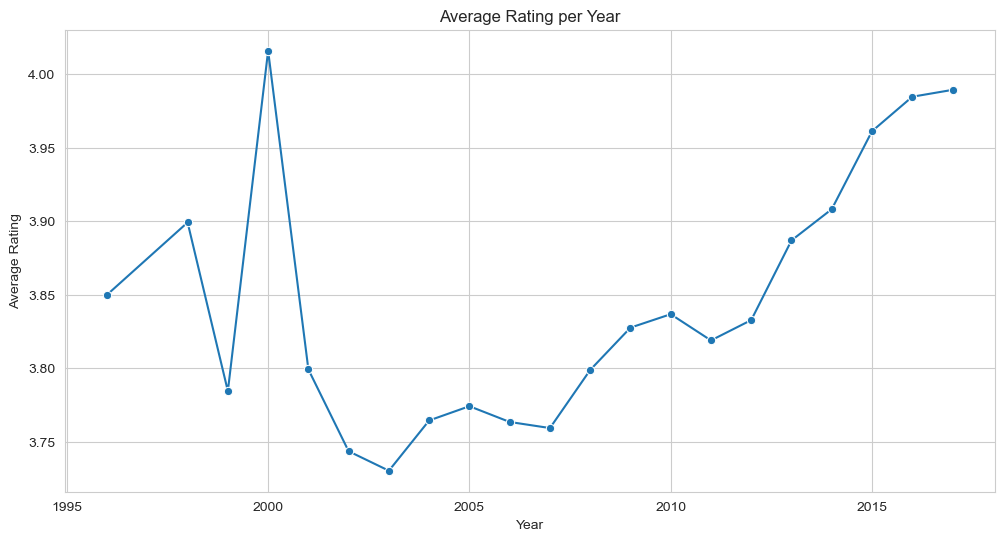

In [122]:
# Compare the average rating per year for all beer for the BeerAdvocate dataset
mean = time_df_beerAdvocate.groupby('year')['rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean, x='year', y='rating', marker='o')

plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating per Year')
plt.show()

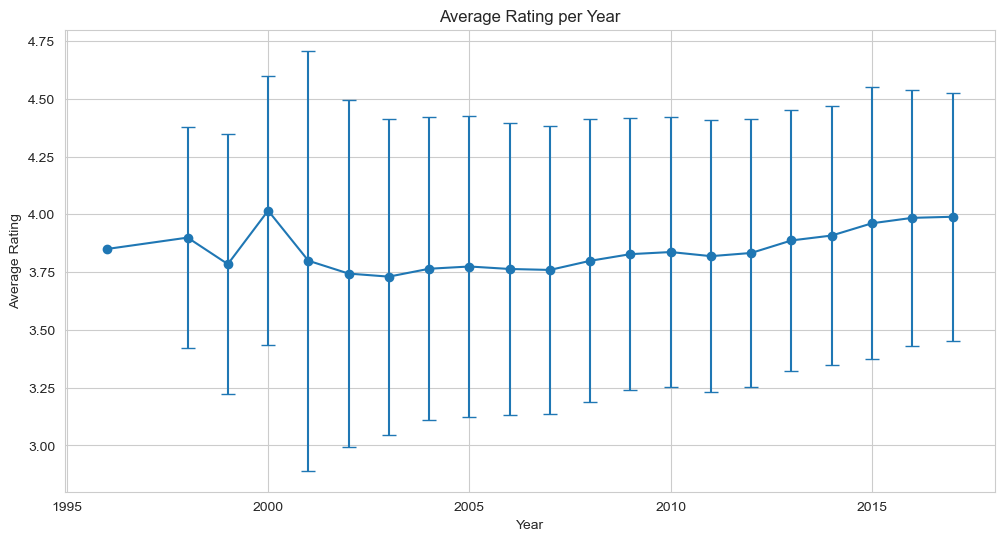

In [123]:
# Compare the average rating per year for all beer with std for the BeerAdvocate dataset
mean = time_df_beerAdvocate.groupby('year')['rating'].mean().reset_index()
# Add the standard deviation to the plot
std = time_df_beerAdvocate.groupby('year')['rating'].std().reset_index()
plt.figure(figsize=(12, 6))
plt.errorbar(mean['year'], mean['rating'], yerr=std['rating'], capsize=5, marker='o')

plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating per Year')
plt.show()

To deepen ours analysis on the time bias, we will compare the ratings during the christmas and new year period and the oktober fest period with the rest of the year to see if there is a difference.

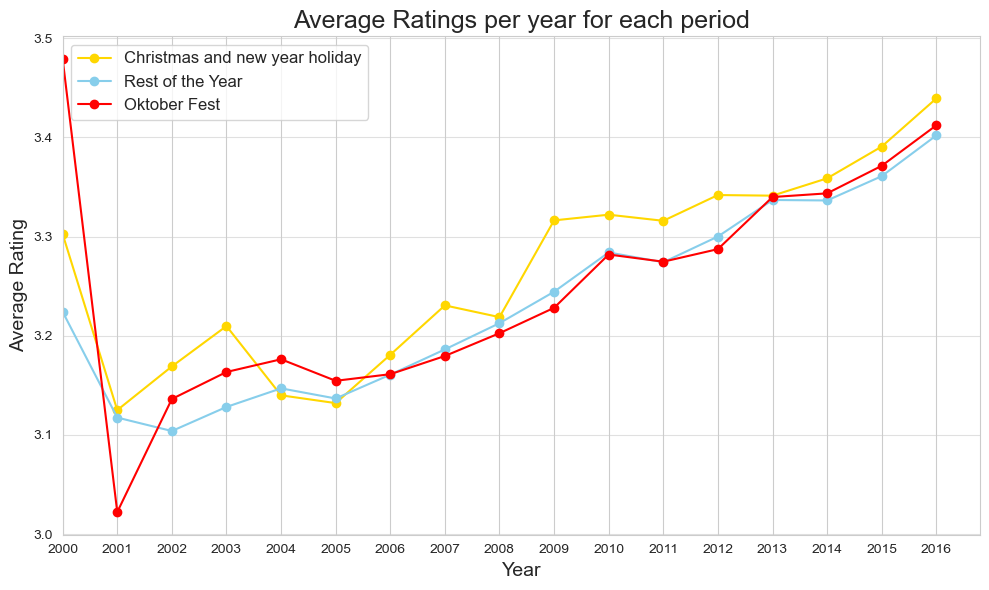

In [144]:
def get_periode(db_time_mod):
    # Create two variables that represent the time of Christmas and Oktober fest period
    xmas_hol = db_time_mod[(db_time_mod['month'] == 12) & (db_time_mod['day'] >= 23) | (db_time_mod['month'] == 1) & (db_time_mod['day'] <= 2)]
    oktober_fest = db_time_mod[(db_time_mod['month'] == 9) & (db_time_mod['day'] >= 16) | (db_time_mod['month'] == 10) & (db_time_mod['day'] <= 3)]

    # Create a variable that represents the rest of the year
    rest_year = db_time_mod[~(((db_time_mod['month'] == 12) & (db_time_mod['day'] >= 23) | (db_time_mod['month'] == 1) & (db_time_mod['day'] <= 2)) & (db_time_mod['month'] == 9) & (db_time_mod['day'] >= 16) | (db_time_mod['month'] == 10) & (db_time_mod['day'] <= 3))]

    return xmas_hol, oktober_fest, rest_year

def time_period_rating(db_time):
    # For this part we want the 2 first days of january to be considered as part of the previous year
    condition = (db_time['month'] == 1) & (db_time['day'] <= 2)
    db_time_mod = db_time.copy()
    db_time_mod.loc[condition, 'year'] -= 1

    xmas_hol, oktober_fest, rest_year = get_periode(db_time_mod)

    # Group by year and compute the average rating for each period per year
    xmas_hol_mean = xmas_hol.groupby(db_time_mod['year'])['rating'].mean()
    oktober_fest_mean = oktober_fest.groupby(db_time_mod['year'])['rating'].mean()
    rest_year_mean = rest_year.groupby(db_time_mod['year'])['rating'].mean()

    # Delete entry for year 2017 as it is not present for all period
    rest_year_mean = rest_year_mean[rest_year_mean.index.isin(oktober_fest_mean.index)]
    xmas_hol_mean = xmas_hol_mean[xmas_hol_mean.index.isin(oktober_fest_mean.index)]

    # Plot the data
    plt.figure(figsize=(10, 6))

    plt.plot(xmas_hol_mean.index, xmas_hol_mean.values, label='Christmas and new year holiday', color='gold', marker='o')
    plt.plot(rest_year_mean.index, rest_year_mean.values, label='Rest of the Year', color='skyblue', marker='o')
    plt.plot(oktober_fest_mean.index, oktober_fest_mean.values, label='Oktober Fest', color='red', marker='o')

    plt.title('Average Ratings per year for each period', fontsize=18)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.6)
    plt.xticks(rest_year_mean.index)
    plt.xlim(2000)
    plt.tight_layout()

time_period_rating(time_df_reviews)

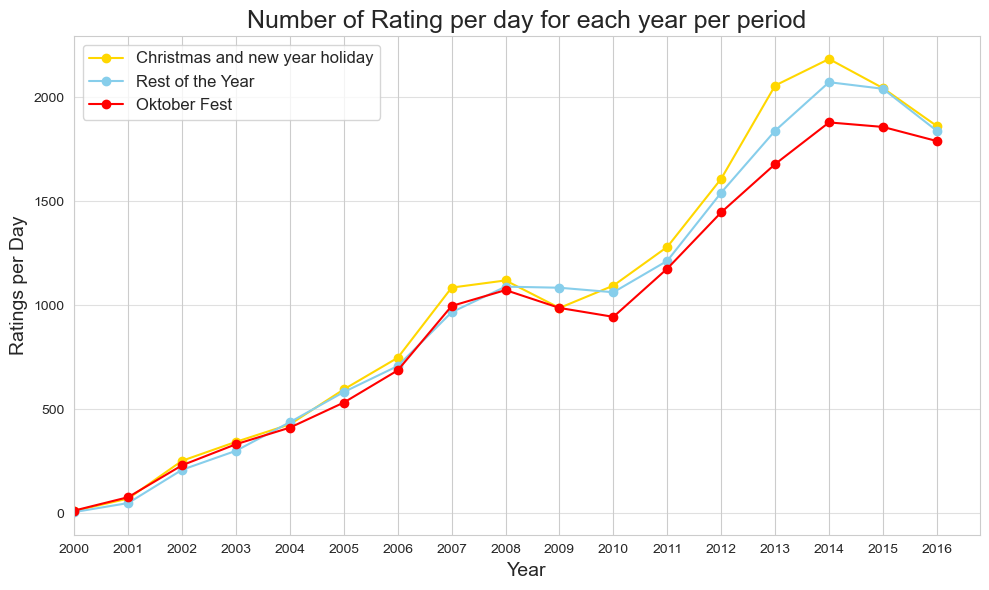

In [145]:
def time_period_per_day(db_time):
    # Number of day per period
    xmas_hol_days = 11
    oktober_fest_days = 18
    rest_year_Days = 365 - xmas_hol_days - oktober_fest_days

    # For this part we want the 2 first days of january to be considered as part of the previous year
    condition = (db_time['month'] == 1) & (db_time['day'] <= 2)
    db_time_mod = db_time.copy()
    db_time_mod.loc[condition, 'year'] -= 1

    xmas_hol, oktober_fest, rest_year = get_periode(db_time_mod)

    # Count the number of ratings per day for each period per year
    xmas_hol_rating = xmas_hol.groupby(db_time['year'])['rating'].count() / xmas_hol_days
    oktober_fest_rating = oktober_fest.groupby(db_time['year'])['rating'].count() / oktober_fest_days
    rest_year_rating = rest_year.groupby(db_time['year'])['rating'].count() / rest_year_Days

    # Delete entry for year 2017 as it is not present for all period
    rest_year_rating  = rest_year_rating[rest_year_rating.index.isin(oktober_fest_rating.index)]
    xmas_hol_rating = xmas_hol_rating[xmas_hol_rating.index.isin(oktober_fest_rating.index)]

    # Plot the data
    plt.figure(figsize=(10, 6))

    plt.plot(xmas_hol_rating.index, xmas_hol_rating.values, label='Christmas and new year holiday', color='gold', marker='o')
    plt.plot(rest_year_rating.index, rest_year_rating.values, label='Rest of the Year', color='skyblue', marker='o')
    plt.plot(oktober_fest_rating.index, oktober_fest_rating.values, label='Oktober Fest', color='red', marker='o')

    plt.title('Number of Rating per day for each year per period', fontsize=18)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Ratings per Day', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.6)
    plt.xticks(rest_year_rating.index)
    plt.xlim(2000)
    plt.tight_layout()

time_period_per_day(time_df_reviews)

(3.6, 4.2)

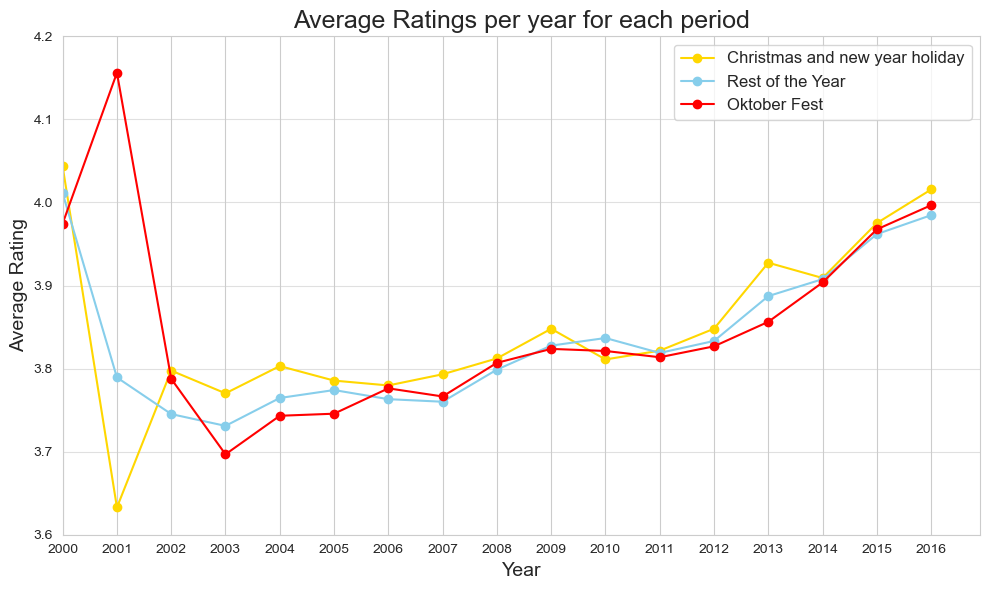

In [147]:
time_period_rating(time_df_beerAdvocate)
plt.ylim(3.6, 4.2)

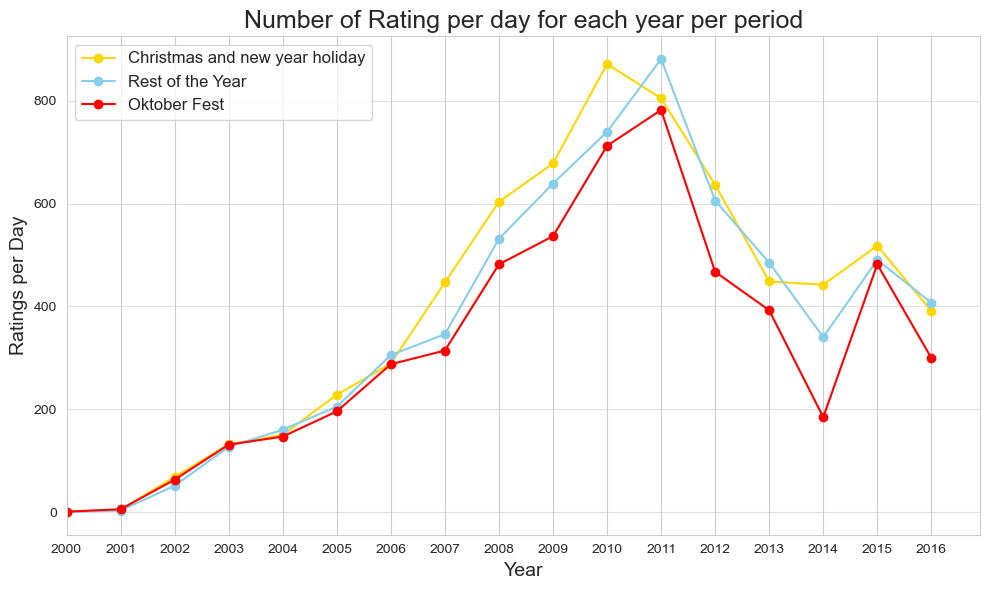

In [148]:
time_period_per_day(time_df_beerAdvocate)